In [1]:
import pandas as pd
df = pd.read_csv("intern_task.csv")

In [2]:
df.head()

,rank,query_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_134,feature_135,feature_136,feature_137,feature_138,feature_139,feature_140,feature_141,feature_142,feature_143
0,0,10,1.0,0.0,1.0,3.0,3.0,0.333333,0.0,0.333333,...,0.0,0.000000,0.454545,0.890238,8.655534,1.000000,0.077778,0.002222,1.0,0.333333
1,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.773976,23.130514,0.000000,0.027826,0.000430,44.0,14.666667
2,0,10,3.0,0.0,2.0,0.0,3.0,1.000000,0.0,0.666667,...,0.0,0.000000,0.000000,0.918308,13.351339,0.000000,0.014925,0.000104,22.0,7.333333
3,1,10,3.0,0.0,3.0,0.0,3.0,1.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.975355,18.240926,0.000000,0.053140,0.000255,8.0,2.666667
4,2,10,3.0,0.0,3.0,1.0,3.0,1.000000,0.0,1.000000,...,273.0,79.670665,0.200000,0.990119,31.786048,0.333333,0.046512,0.000307,24.0,8.000000


In [3]:
df.sort_values(by=['query_id', 'rank'], inplace=True)

<Axes: >

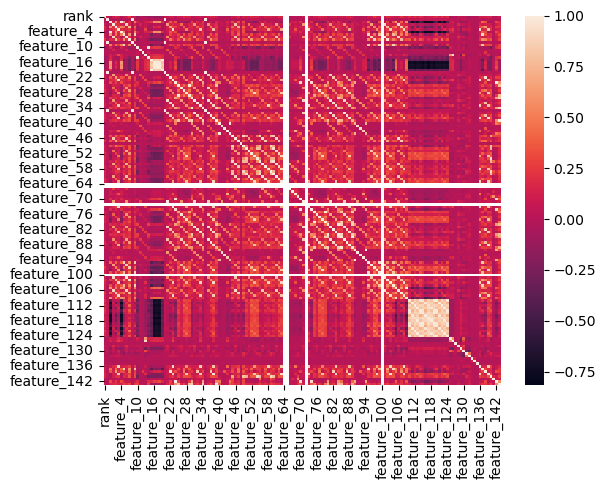

In [4]:
import seaborn as sns
sns.heatmap(df.corr())

Кажется, что некоторые фичи в конце очень коррелированы. Присмотримся поближе

<Axes: >

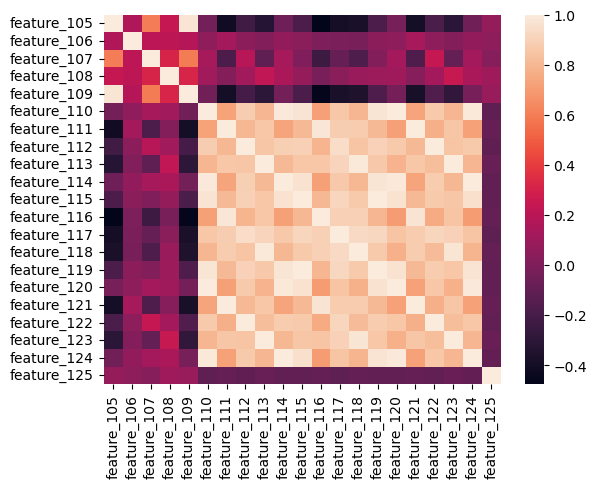

In [5]:
columns = [f"feature_{i}" for i in range(105, 126)]
sns.heatmap(df[columns].corr())

Ну да, из фичей со 110 по 124 можно оставить только одну из них

In [6]:
df = df.drop(columns=columns[6:])

В начале, кажется, тоже наблюдается подобная картина

<Axes: >

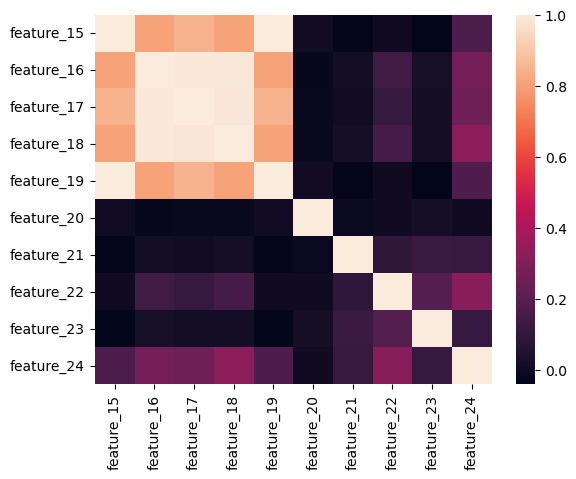

In [7]:
columns = [f"feature_{i}" for i in range(15, 25)]
sns.heatmap(df[columns].corr())

Из фичей с 15 по 19 оставим только 19

In [8]:
df = df.drop(columns=columns[:4])

Ну и некоторые фичи коррелированы с коэффициентом единица. Их тоже нужно убрать

In [9]:
df = df.drop(columns=[
    'feature_64',
    'feature_65',
    'feature_72',
    'feature_100'
])
df = df.dropna()

Если лассо-регрессия достойно справится с задачей, то на этом можно будет закончить. Если нет, то на отобранных ею фичах пообучаю другие модели

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['rank']), df['rank'], test_size=0.2, shuffle=False)

In [11]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
lasso = Lasso(max_iter=10000)
sfm = SelectFromModel(lasso)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(max_iter=10000))

In [12]:
from sklearn.metrics import ndcg_score
preds = [int(pred) for pred in sfm.estimator_.predict(X_test)]
ndcg_score([y_test], [preds])

0.889684732553987

Посмотрим, как будут вести себя модели на отобранных фичах

In [14]:
columns_to_change = [col for col in df.columns if col != 'rank']
new_df = pd.DataFrame(sfm.transform(df[columns_to_change]))
new_df['rank'] = df['rank']
new_df.head()

,0,1,2,3,4,5,6,7,rank
0,10.0,10.0,30.0,1.555556,24.430262,1.375925,7.738967,104.0,0
1,10.0,522.0,536.0,32.666667,85.567962,2.323455,15.027157,11.0,1
2,10.0,10.0,19.0,0.000000,0.000000,0.000000,0.000000,1.0,0
3,10.0,919.0,929.0,2.666667,7.398760,0.000000,5.285207,1.0,1
4,10.0,129.0,139.0,0.666667,20.087656,2.751851,0.000000,6.0,2


In [15]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(columns=['rank']), new_df['rank'], test_size=0.15, stratify=new_df['rank'])

In [16]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [17]:
preds = nb.predict(X_test)
ndcg_score([y_test], [preds])

0.8660641494669569

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [19]:
preds = clf.predict(X_test)
ndcg_score([y_test], [preds])

0.8775711955884458

In [20]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators' : list(range(100, 901, 200)),
    'max_depth' : [1, 2, 5, 10, 30, 50, 100],
    'min_samples_leaf' : [5, 10, 30, 50]
}
grid = RandomizedSearchCV(RandomForestClassifier(), params)
grid = grid.fit(X_train, y_train)

In [21]:
grid.best_params_
# По некоторым причинам мне пришлось перезапустить все ячейки. Предыдущую я перезапускать не стал, чтобы не тратить
# лишнее время. В коде ниже использованы параметры, подобранные search-ем при первом запуске

In [22]:
best_clf = RandomForestClassifier(n_estimators=900, min_samples_leaf=5, max_depth=50, n_jobs=8)
best_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=50, min_samples_leaf=5, n_estimators=900)

In [23]:
preds = best_clf.predict(X_test)
ndcg_score([y_test], [preds])

0.8799835959226479